### 옷 분리
    
    최초 작성일 : 20/03/09
    작성자 : 양희승
    
    작성내용 : 무신사 이미지를 통해 옷 색깔 판별하기 위한 옷분리 코드
    
    
    수정내용 :
        전체 코드 수정
        
        20/03/20
            - 분리코드 수정
            - DB 적재 코드 추가
            - 옷 색 판별 코드 추가
            
        20/03/23
            - 분리코드 수정  이미지 RGBA -> 투명배경 흰색 처리
            - DB연결
            
        20/03/24
            - 옷 이미지 색 추출
            - HSV 변환
            - DB 적재 테스트

In [248]:
import pymysql
import cv2 as cv
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import colour
from sklearn.cluster import KMeans
import utils
import time
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import warnings
warnings.filterwarnings(action='ignore')

d:\users\yhs\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [249]:
# ## DB 연결 데이터 
config = {"host":"192.168.0.41", "user":"cai", "passwd":"1234", "db":"final"}
# config = {"host":"49.142.181.65", "user":"cai","passwd":"1234", "db":"final"}
conn = pymysql.connect(**config)

# 모델, file name저장
files = os.listdir("Fashion-AI/input/")
model = load_model("Fashion-AI/model/topwears.h5")

In [241]:
print(len(files))

2189


In [250]:
#  옷 분할
class fashion_tools(object):
    def __init__(self,imageid,version=1.1):
        self.imageid = imageid
        self.model = model
        self.version = version
        
    def get_dress(self,stack=False):
        name =  self.imageid
        file = cv.imread(name)
        file = tf.image.resize_with_pad(file,target_height=512,target_width=512)
        rgb  = file.numpy()
        file = np.expand_dims(file,axis=0)/ 255.
        seq = self.model.predict(file)
        seq = seq[3][0,:,:,0]
        seq = np.expand_dims(seq,axis=-1)
        c1x = rgb*seq
        c2x = rgb*(1-seq)
        cfx = c1x+c2x
        dummy = np.ones((rgb.shape[0],rgb.shape[1],1))
        rgbx = np.concatenate((rgb,dummy*255),axis=-1)
        rgbs = np.concatenate((cfx,seq*255.),axis=-1)
        if stack:
            stacked = np.hstack((rgbx,rgbs))
            return stacked
        else:
            alpha_val = np.zeros((512,512))
            result = np.array(rgbs[:,:,0:3])
            for i in range(len(rgbs[:,:,3])) :
                for j in range(len(rgbs[:,:,3][i])):
                    alpha_val[i][j] = round(rgbs[:,:,3][i][j], 2)
            
            for i in range(len(alpha_val)) :
                for j in range(len(alpha_val[i])) :
                    if (alpha_val[i][j] <= 0.95) :
                        result[i][j][0] = 255.0
                        result[i][j][1] = 255.0
                        result[i][j][2] = 255.0
                        
            return result

In [228]:
## 한번더 경계값 처리 
def grab_cut(img) :
    imgo = image_.astype('uint8')
    height, width = imgo.shape[:2]

    mask = np.zeros(imgo.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (10,10,width-30,height-30)
    cv.grabCut(imgo,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
    img1 = imgo*mask[:,:,np.newaxis]

    background = imgo - img1

    background[np.where((background > [0,0,0]).all(axis = 2))] = [255,255,255]

    final = background + img1  ## BGR
#     show_img = cv.cvtColor(final, cv.COLOR_BGR2RGB)  ## RGB
#     plt.imshow(show_img)
#     plt.show()
    return final

In [229]:
# 색에 대한 비율 표기
def color_ratio(clt) :
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist

In [230]:
# 단지 색 비율 그래프 나타내기 위함
def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    total = []
    for i in range(len(hist)):
        total.append((hist[i], centroids[i]))
    total.sort(reverse=True)
    for percent, color in total:
        endX = startX + (percent * 300)
        cv.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    
    return bar


In [251]:
start_idx = int(input("시작 숫자 입력 : "))
end_idx = int(input("종료 숫자 입력 : "))
# end_idx = len(files)

시작 숫자 입력 : 187
종료 숫자 입력 : 500


In [252]:
start_time = time.time()

for i in range(start_idx, end_idx) :
    
#     f = "Fashion-AI/input/27651.jpg"    
    prdt_code = files[i].replace(".jpg", "")
    f = "Fashion-AI/input/"+files[i]
    o = "Fashion-AI/output/"+prdt_code

    api    = fashion_tools(f, model)    
    try :
        image_ = api.get_dress(False)    
    except ValueError :
        print(prdt_code, " 에러")
        
    ####### 코드 제일 느린부분######
    image_grab = grab_cut(image_)
    ################################  속도처리 요망
    
    
    img = cv.cvtColor(image_grab, cv.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0]*img.shape[1], 3))
    clt = KMeans(n_clusters=5)
    clt.fit(img)
    
    hist = color_ratio(clt)
    temp = np.array(clt.cluster_centers_)
    delete_idx = 0
    for i in range(0, len(temp)) :
        check_color = (color[i][0] >= 254) and (color[i][1] >= 254) and (color[i][2] >= 254)
        if check_color :
            delete_idx = i        

    hist = np.delete(hist, delete_idx)
    temp = np.delete(temp, delete_idx, 0)
    
    max_idx = hist.argmax()
    
    rgb_color = temp[max_idx]
    arr_RGB_color = np.array(rgb_color)
    float_arr_RGB_color = arr_RGB_color / 255
    float_tp_RGB_color = tuple(float_arr_RGB_color)
    HSV_color = colour.RGB_to_HSV(float_tp_RGB_color)


    HSV_color2 = np.array([round(HSV_color[0]*359, 3), round(HSV_color[1] * 100, 3), round(HSV_color[2] * 100, 3)])

    h = str(round(HSV_color2[0], 2))
    s = str(round(HSV_color2[1], 2))
    v = str(round(HSV_color2[2], 2))
    
    # DB 적재
    cursor = conn.cursor();
    sql = "UPDATE PRDT_IMAGE SET H={},S={},V={} WHERE PRDT_CODE={}".format(h,s,v, prdt_code)
    cursor.execute(sql)
    conn.commit()

    #해당파일 기록
    fw = open("Fashion-AI/input/result/"+prdt_code+".txt", 'w')
    fw.write("h   s   v\n")
    fw.write(h + "   " + s + "   " + v)
    fw.close()
    print("-",end="")
    if(i%100 == 1) :
        print(i + " 개 완료")
    
end_time = time.time()
print("total time : ", end_time - start_time, "초")

cursor.close()


155478  에러
-155479  에러
----------------------------161610  에러
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------total time :  2721.9790885448456 초


# 밑에는 테스트용 코드

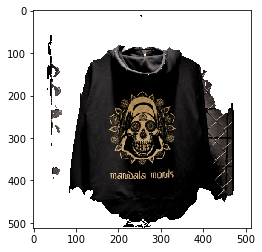

In [212]:
f = "Fashion-AI/input/27651.jpg"
o = "Fashion-AI/output/"+files[i].replace(".jpg", "")
api    = fashion_tools(f, model)    
image_ = api.get_dress(False)
image_grab = grab_cut(image_)

In [213]:
img = cv.cvtColor(image_grab, cv.COLOR_BGR2RGB)
# img = image_grab
img = img.reshape((img.shape[0]*img.shape[1], 3))
clt = KMeans(n_clusters=5)
clt.fit(img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [217]:
hist = color_ratio(clt)
temp = np.array(clt.cluster_centers_)
delete_idx = 0
for i in range(0, len(temp)) :
    check_color = (color[i][0] >= 254) and (color[i][1] >= 254) and (color[i][2] >= 254)
    if check_color :
        print(color[i])
        print("작동됨?", i)
        delete_idx = i        

hist = np.delete(hist, delete_idx)
temp = np.delete(temp, delete_idx, 0)
print(hist)
print(temp)

[ 254.97014758  254.96514104  254.95839342  255.        ]
작동됨? 1
[ 0.26784515  0.04176712  0.14961243  0.03026581]
[[   4.32380722    3.7334492     3.76990583]
 [  86.32723596   75.54334038   66.85485798]
 [  36.53187757   32.79851543   31.78181402]
 [ 172.08106741  145.97736183  109.61540407]]


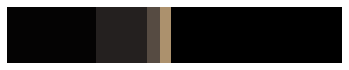

In [215]:
# 그래프임 무시해도 괜찮
bar = plot_colors(hist, temp)  
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [218]:
# 제일 높은 수치만 뽑기
max_idx = hist.argmax()
# print("수치 : ", hist[max_idx])
# print("색(RGB) : ", temp[max_idx][0:3])

In [219]:
# RGB -> HSV 변환
rgb_color = temp[max_idx]
arr_RGB_color = np.array(rgb_color)
float_arr_RGB_color = arr_RGB_color / 255
float_tp_RGB_color = tuple(float_arr_RGB_color)
HSV_color = colour.RGB_to_HSV(float_tp_RGB_color)


HSV_color2 = np.array([round(HSV_color[0]*359, 3), round(HSV_color[1] * 100, 3), round(HSV_color[2] * 100, 3)])

# print("HSV 값 : ", HSV_color2)

h = str(round(HSV_color2[0], 2))
s = str(round(HSV_color2[1], 2))
v = str(round(HSV_color2[2], 2))
print(h,s,v)


355.3 13.65 1.7


In [225]:
# DB 적재
cursor = conn.cursor();
prdt_code = "27651"
sql = "UPDATE PRDT_IMAGE SET H={},S={},V={} WHERE PRDT_CODE={}".format(h,s,v, prdt_code)
cursor.execute(sql)
conn.commit()
